This code demonstrates the training and evaluation of a GNN model for node classification using a 3D coordinate dataset. The model learns to predict binary labels based on the spatial information of the nodes in the graph.

Blue = incorrect prediction

Red = correct prediction

In [1]:
import torch
import dgl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate random 3-coordinate data
num_points = 250
coords = np.random.rand(num_points, 3)

# Create a graph using DGL
g = dgl.DGLGraph()
g.add_nodes(num_points)
g.ndata['coord'] = torch.tensor(coords, dtype=torch.float32)

# Add self-loops to the graph
g.add_edges(g.nodes(), g.nodes())

C:\Users\Bianbian's Computer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [3]:
# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GNN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = torch.relu(self.conv2(g, x))
        g.ndata['h'] = x
        g.update_all(message_func=dgl.function.copy_u('h', 'm'), reduce_func=dgl.function.sum('m', 'x'))
        x = torch.relu(self.fc(g.ndata['x']))
        return torch.softmax(x, dim=1)

# Define the training loop
def train(model, g, features, labels, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    #we could try different optimizer's if needed; historically I always use the Adam as a base, most accurate and fastest.
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(g, features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    
    return model

# Generate random labels for classification (0 or 1)
labels = torch.randint(0, 2, (num_points,))

# Split the data into training and test sets
train_mask = torch.randperm(num_points)[:int(0.8 * num_points)]
test_mask = torch.ones(num_points, dtype=torch.bool)
test_mask[train_mask] = False

Epoch 10/500, Loss: 0.6931473612785339
Epoch 20/500, Loss: 0.6931473612785339
Epoch 30/500, Loss: 0.6931473612785339
Epoch 40/500, Loss: 0.6931473612785339
Epoch 50/500, Loss: 0.6931473612785339
Epoch 60/500, Loss: 0.6931473612785339
Epoch 70/500, Loss: 0.6931473612785339
Epoch 80/500, Loss: 0.6931473612785339
Epoch 90/500, Loss: 0.6931473612785339
Epoch 100/500, Loss: 0.6931473612785339
Epoch 110/500, Loss: 0.6931473612785339
Epoch 120/500, Loss: 0.6931473612785339
Epoch 130/500, Loss: 0.6931473612785339
Epoch 140/500, Loss: 0.6931473612785339
Epoch 150/500, Loss: 0.6931473612785339
Epoch 160/500, Loss: 0.6931473612785339
Epoch 170/500, Loss: 0.6931473612785339
Epoch 180/500, Loss: 0.6931473612785339
Epoch 190/500, Loss: 0.6931473612785339
Epoch 200/500, Loss: 0.6931473612785339
Epoch 210/500, Loss: 0.6931473612785339
Epoch 220/500, Loss: 0.6931473612785339
Epoch 230/500, Loss: 0.6931473612785339
Epoch 240/500, Loss: 0.6931473612785339
Epoch 250/500, Loss: 0.6931473612785339
Epoch 260

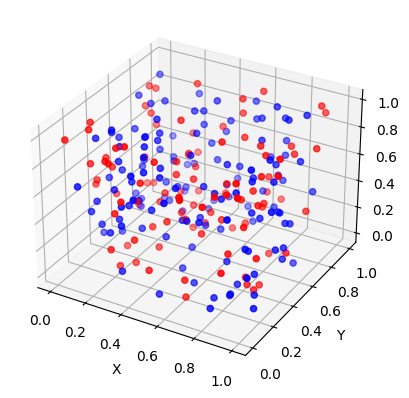

In [4]:
# Create the GNN model
model = GNN(in_feats=3, hidden_size=16, num_classes=2)

# Train the model
model = train(model, g, g.ndata['coord'], labels, epochs=500)

# Evaluate the model
with torch.no_grad():
    logits = model(g, g.ndata['coord'])
    predicted_labels = torch.argmax(logits, dim=1)
    accuracy = torch.sum(predicted_labels == labels) / num_points
    print(f'Accuracy: {accuracy.item()}')

# Plot the points and their predicted labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if pred == label else 'b' for pred, label in zip(predicted_labels, labels)]
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [5]:
# Red = correct predictions, blue = incorrect predictions.